# Fast and efficient preprocessing of scRNA-seq with `kallisto` | `bustools` | `kb-python`


This notebook provides a complete workflow to quantify single-cell RNA-seq data using using **kb-python** (kallisto|bustools).

---
[Md. Jubayer Hossain](https://mdjubayerhossain.com/)

Founder & CEO, [DeepBio Ltd.](https://deepbioltd.com/)

## Step 1: Install Required Packages

Install kb-python and ffq (for downloading SRA data).

In [3]:
# Install kb-python and ffq
%time
!pip install kb-python ffq -q

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 6.44 μs


In [16]:
# Set up main working directory
import os
working_dir = "/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/assignments/workflow/sc-kb-wrokflow"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

In [17]:
# Define folder structure
folders = [
    "reference",
    "raw_data",
    "processed_data",
    "results",
    "results/figures",
    "results/tables"
]

# Create folders
for folder in folders:
    path = os.path.join(working_dir, folder)
    os.makedirs(path, exist_ok=True)

In [18]:
# Set Save paths for easy use later
reference_dir = os.path.join(working_dir, "reference")
raw_data_dir = os.path.join(working_dir, "raw_data")
processed_data_dir = os.path.join(working_dir, "processed_data")
results_dir = os.path.join(working_dir, "results")
figures_dir = os.path.join(working_dir, "results/figures")
tables_dir = os.path.join(working_dir, "results/tables")

## Step 2: Build Reference Index

We'll use kb-python's built-in reference download for mouse. This will download the mouse transcriptome and create an index.

Before we can quantify gene expression from raw FASTQ files, we need to create a reference index.
This index is essential because tools like kb-python (Kallisto | Bustools) must know:

- Which transcripts exist in the organism?
- Where each transcript starts and ends?
- Which transcripts map to which genes?

This allows the reads to be pseudoaligned quickly and accurately.

In [7]:
# Check directory path
!pwd

/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/assignments/workflow/sc-kb-wrokflow


In [8]:
# List directories
!ls

processed_data	raw_data  reference  results


In [9]:
# Check results
!ls results

figures  tables


In [10]:
# Download and build mouse reference (this may take 10-15 minutes)
# For human: -d human
# For Mouse: -d mouse
%time
!kb ref -d human -i reference/index.idx -g reference/t2g.txt

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.48 μs
[2025-12-25 16:27:47,566]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


In [11]:
!ls reference

index.idx  t2g.txt


This command downloads and builds the human transcriptome reference needed for `pseudoalignment` and count matrix generation in single-cell RNA-seq.

- `kb ref` prepares everything needed for kb count, including:
    - downloading the transcriptome
    - generating the kallisto index
    - building the transcript-to-gene (t2g) mapping file

- `-d human`
    - Tells `kb-python` to automatically download a predefined HUMAN reference dataset.
    - No need to manually supply FASTA or GTF files.

- `-i reference/index.idx`
    - Specifies where to save the kallisto index, which is used for fast pseudoalignment.
- `-g reference/t2g.txt`
    - Creates a transcript-to-gene mapping file.
    - Bustools uses this file to convert transcript counts into gene counts.

### Alternative: Manual Reference Building

If you prefer to build the reference manually from specific genome and GTF files:

In [ ]:
# OPTIONAL: Manual reference building (uncomment to use)
# Download genome and GTF from Ensembl
# !wget ftp://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
# !wget ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz

# Build reference
# !kb ref \
#   -i reference/index.idx \
#   -g reference/t2g.txt \
#   -f1 reference/transcriptome.fa \
#   Mus_musculus.GRCm39.dna.primary_assembly.fa.gz \
#   Mus_musculus.GRCm39.109.gtf.gz

## Step 3: Download FASTQ Files

Download the raw sequencing data from `SRA` using `ffq`.

## Dataset
- **GEO Accession**: GSE174609
- **Species**: Homo sapiens
- **Technology**: 10x Genomics Chromium (v3.1 chemistry)
- **Samples**:12
- **SRA Project**: PRJNA730788
- **Paper**: https://link.springer.com/article/10.1186/s12967-022-03702-2


In [12]:
# Get sample information
import os
import json
import subprocess

# Sample IDs from the SRA project
samples = [
    'SRR14575500', # healthy (R1, R2)
    'SRR14575504', # pre-treatment
    'SRR14575508'  # post-treatment
]

print("Samples to download:")
for sample in samples:
    print(f"  - {sample}")

Samples to download:
  - SRR14575500
  - SRR14575504
  - SRR14575508


In [14]:
# Download FASTQ files using ffq
# Note: This will download large files (20-40 GB total)
# Make sure you have sufficient disk space and time
%time
for sample in samples:
    print(f"\nDownloading {sample}...")

    # Get FTP URLs using ffq
    result = subprocess.run(
        ["ffq", "--ftp", sample],
        capture_output=True,
        text=True
    )

    # Parse the JSON output
    data = json.loads(result.stdout)

    # Download FASTQ files
    for entry in data:
        url = entry['url']
        filename = os.path.basename(url)
        output_path = f"raw_data/{filename}"

        if not os.path.exists(output_path):
            print(f"Downloading: {filename}")
            !wget -q --show-progress -O {output_path} {url}
        else:
            print(f"File already exists: {filename}")

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 4.77 μs

Downloading: SRR14575500_1.fastq.gz
SRR14575500_1.fastq   2%[                    ] 160.81M  2.46MB/s    in 2m 11s  
SRR14575500_1.fastq  41%[=======>            ]   3.06G   754KB/s    in 35m 50s 
SRR14575500_1.fastq  51%[++++++++=>          ]   3.82G  1.34MB/s    in 8m 51s  
SRR14575500_1.fastq  55%[++++++++++>         ]   4.11G   539KB/s    in 9m 4s   
SRR14575500_1.fastq  57%[+++++++++++         ]   4.24G  1.69MB/s    in 88s     
SRR14575500_1.fastq  58%[+++++++++++         ]   4.33G  1.69MB/s    in 63s     
SRR14575500_1.fastq  61%[+++++++++++>        ]   4.51G  1.61MB/s    in 1m 58s  
SRR14575500_1.fastq  66%[++++++++++++>       ]   4.88G  1.12MB/s    in 4m 5s   
SRR14575500_1.fastq  70%[+++++++++++++>      ]   5.18G  1.30MB/s    in 3m 29s  
SRR14575500_1.fastq  74%[++++++++++++++      ]   5.49G   973KB/s    in 4m 24s  
SRR14575500_1.fastq  75%[++++++++++++++>     ]   5.60G  1.39MB/s    in 79s     
SRR14575500_1.fastq

### Alternative: Use SRA Toolkit (if ffq has issues)

In [ ]:
# ALTERNATIVE: Download using SRA toolkit
# !pip install sra-tools -q

# for sample in samples:
#     print(f"Downloading {sample}...")
#     !fastq-dump --split-files --gzip --outdir raw_data {sample}

## Step 4: Quantify with kb-python (Pseudoalignment and UMI counting)

Now we'll use kb count to process the FASTQ files. Since this is 10x Chromium data, we'll use the `10xv2/v3` technology specification.

In [9]:
# Process each sample
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
%time
for sample in samples:
    print(f"\n{'='*60}")
    print(f"Processing sample: {sample}")
    print(f"{'='*60}\n")

    # Define input and output paths
    r1 = f"workflow/sc-kb-wrokflow/raw_data/{sample}_1.fastq.gz"
    r2 = f"workflow/sc-kb-wrokflow/raw_data/{sample}_2.fastq.gz"
    output_dir = f"output/{sample}"

    # Run kb count
    # Note: Adjust -x parameter if needed (try 10xv3 if 10xv2 doesn't work well)
    !kb count \
        -i workflow/sc-kb-wrokflow/reference/index.idx \
        -g workflow/sc-kb-wrokflow/reference/t2g.txt \
        -x 10xv3 \
        -o {output_dir} \
        --h5ad \
        -t 4 \
        {r1} {r2}

    print(f"\nCompleted processing: {sample}")
    print(f"Output directory: {output_dir}")

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.77 μs

Processing sample: SRR14575500

[2025-12-26 12:06:24,993]    INFO [count] Using index workflow/sc-kb-wrokflow/reference/index.idx to generate BUS file to output/SRR14575500 from
[2025-12-26 12:06:24,994]    INFO [count]         workflow/sc-kb-wrokflow/raw_data/SRR14575500_1.fastq.gz
[2025-12-26 12:06:24,994]    INFO [count]         workflow/sc-kb-wrokflow/raw_data/SRR14575500_2.fastq.gz
[2025-12-26 12:30:22,686]    INFO [count] Sorting BUS file output/SRR14575500/output.bus to output/SRR14575500/tmp/output.s.bus
[2025-12-26 12:31:26,604]    INFO [count] On-list not provided
[2025-12-26 12:31:26,619]    INFO [count] Copying pre-packaged 10XV3 on-list to output/SRR14575500
[2025-12-26 12:31:27,283]    INFO [count] Inspecting BUS file output/SRR14575500/tmp/output.s.bus
[2025-12-26 12:31:48,426]    INFO [count] Correcting BUS records in output/SRR14575500/tmp/output.s.bus to output/SRR14575500/tmp/output.s.c.bus with on-list

**Understanding kb count parameters:**

- `-i`: Index file created in Step 2
- `-g`: Transcript-to-gene mapping file
- `-x 10xv3`: Technology specification (10x Chromium v3)
- `-o`: Output directory
- `--h5ad`: Generate AnnData h5ad file for easy loading in Python
- `-t 4`: Use 4 threads (adjust based on available resources)
- Last arguments: Read 1 and Read 2 FASTQ files

## Step 5: Load and Explore Results

Load the quantification results using scanpy for downstream analysis.

In [4]:
# Install Single-Cell Ecostem
%time
!pip install scanpy leidenalg pybiomart -q

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 4.53 μs


In [22]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [25]:
# Load the data for each sample
adatas = {}

# Sample
samples = [
    'SRR14575500', # healthy (R1, R2)
    'SRR14575504', # pre-treatment
    'SRR14575508'  # post-treatment
]

for sample in samples:
    h5ad_path = f"/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/assignments/workflow/sc-kb-wrokflow/output/{sample}/counts_unfiltered/adata.h5ad"
    print(f"Loading {sample}...")
    adata = sc.read_h5ad(h5ad_path)
    adata.obs['sample'] = sample
    adatas[sample] = adata
    print(f"  Shape: {adata.shape}")
    print(f"  Genes: {adata.n_vars}")
    print(f"  Cells: {adata.n_obs}\n")

Loading SRR14575500...
  Shape: (931056, 39546)
  Genes: 39546
  Cells: 931056

Loading SRR14575504...
  Shape: (1002387, 39546)
  Genes: 39546
  Cells: 1002387

Loading SRR14575508...
  Shape: (1048238, 39546)
  Genes: 39546
  Cells: 1048238



In [26]:
# Save the data for each sample
import os

samples = [
    'SRR14575500',
    'SRR14575504',
    'SRR14575508'
]

for sample in samples:
    h5ad_path = f"/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/assignments/workflow/sc-kb-wrokflow/output/{sample}/counts_unfiltered/adata.h5ad"

    adata = sc.read_h5ad(h5ad_path)
    adata.obs['sample'] = sample

    output_path = os.path.join(processed_data_dir, f"{sample}.h5ad")
    adata.write(output_path)

In [27]:
# Merge samples if you want combined analysis
adata_merged = sc.concat(adatas.values(), label="sample", keys=samples)

print(f"Merged dataset shape: {adata_merged.shape}")

# Export the merged data
adata_merged.write(os.path.join(processed_data_dir, "merged_data.h5ad"))

/home/mim/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Merged dataset shape: (2981681, 39546)


## Step 6: Basic QC

In [ ]:
adata = sc.read_h5ad("/content/drive/MyDrive/01-Projects/sc-kb-wrokflow/processed_data/SRR14575500.h5ad")

In [ ]:
adata # (cell x gene)

AnnData object with n_obs × n_vars = 1028055 × 39546
    obs: 'sample'

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a technique used to simplify complex data without losing the most important information.

Imagine you are taking a photograph 📸 of a 3D object; you are essentially reducing 3D information into a 2D image.

PCA helps us find the "best angle" for that photo so we can see as much detail as possible.

Let’s explore this together. I’ll ask guiding questions along the way to help us dive deeper into how it works.

To get started, which of these paths interests you most?

- **The "Shadow" Analogy:** A visual way to understand how we project high-dimensional data onto a flat surface.
- **Variance & Features:** Learning how PCA decides which parts of the data are "important" and which are just "noise."
- **Real-World Use Cases:** Seeing how PCA is used in fields like facial recognition 👤 or genetics.

computing PCA
    with n_comps=50
    finished (0:00:20)


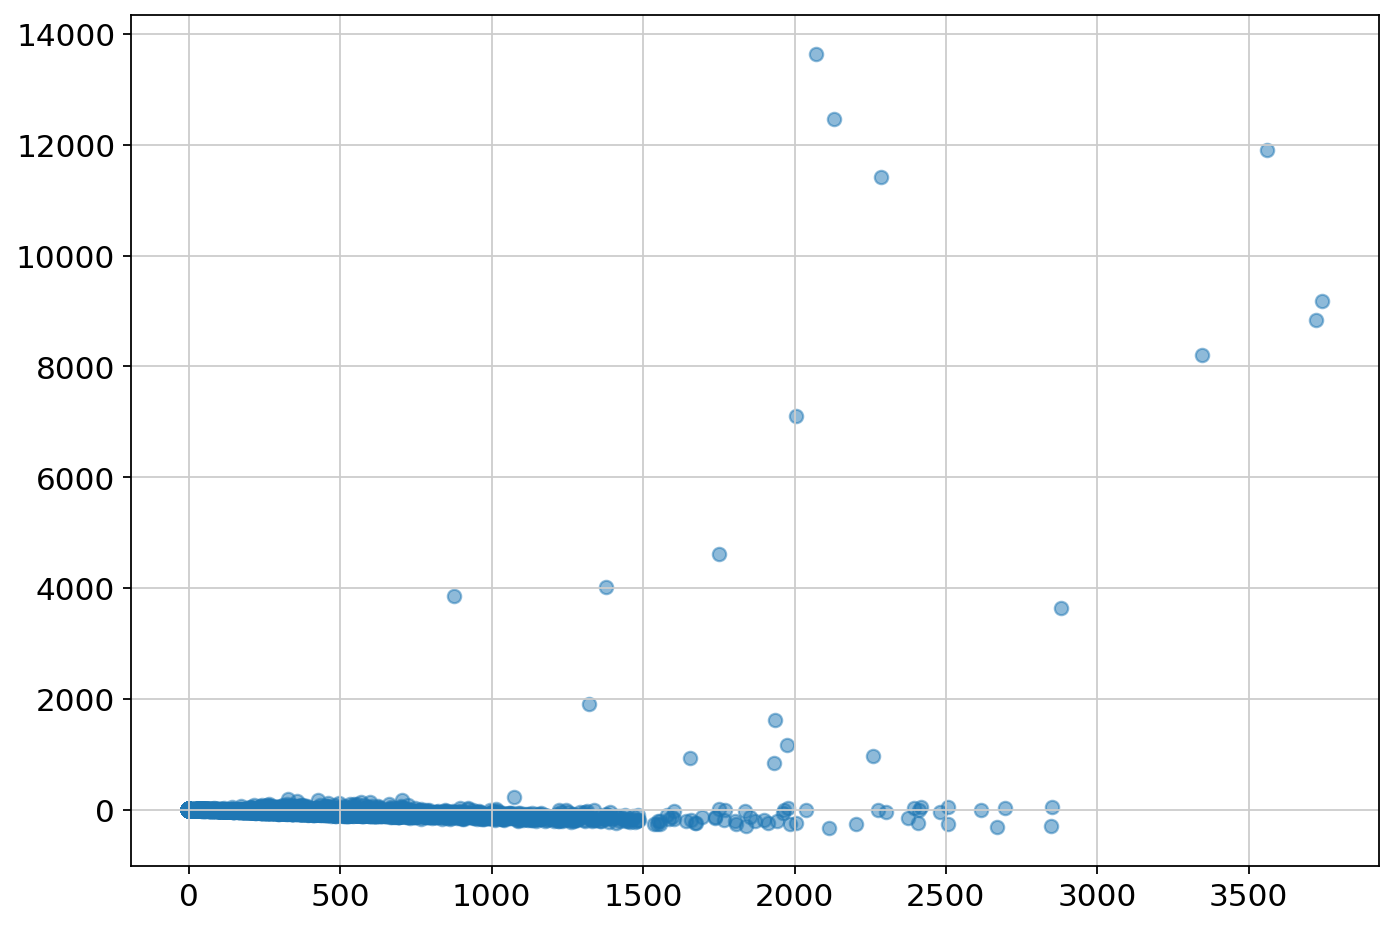

In [ ]:
sc.pp.pca(adata)
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(adata.obsm['X_pca'][:,0], adata.obsm['X_pca'][:,1], alpha=0.5)
plt.show()

This plot is a common first step in analyzing single-cell data. It visualizes the result of Principal Component Analysis (PCA), which takes thousands of gene expressions and boils them down into a few "Principal Components" (PCs) that capture the most variation.

- The Axes: The `x-axis` represents `PC1` and the `y-axis` represents `PC2`. These are the two directions in your data with the highest variance.
- The Points: Each dot represents a `single cell`.
- The Shape: Notice how the points are clustered heavily near `$(0,0)$` but a few "stretch" out toward the top and right. This suggests that while most cells are similar, there are specific groups or biological processes causing significant differences in some cells.

Let's look closer at what this is telling us about our dataset. I'll ask a few questions to help us interpret the biology behind the math. Which area should we explore first?

- Spotting Outliers: We can discuss those points far away from the main cluster and what they might represent (e.g., specific cell types or technical noise).
- Variance Explained: We can look at how much "information" is actually captured in these first two components versus the ones we aren't seeing.
- Data Quality: We can explore if this `"L-shape"` distribution suggests our data needs more preprocessing (like normalization or filtering).

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper:
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

The knee plot can be used to threshold cells based on the number of UMI counts they contain. The threshold is applied at the "knee", where there is a sharp dropoff in the number of UMIs per cell. In this example we use the nunber 3979 based on the publication describing the data.

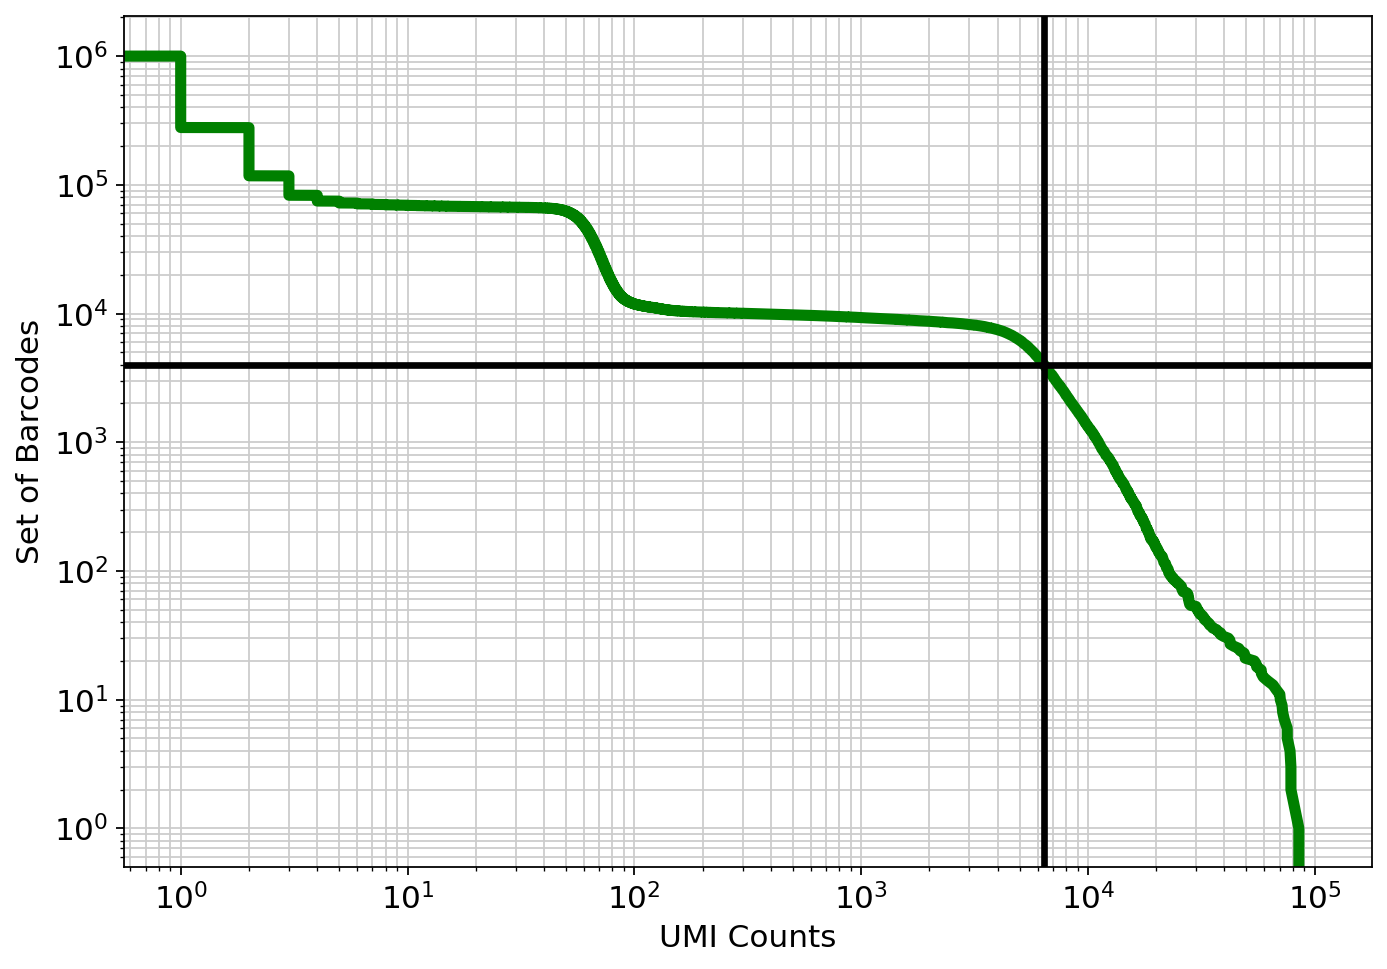

In [ ]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  3979#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")

### Filter Empty Droplets

In [ ]:
adata

AnnData object with n_obs × n_vars = 1028055 × 39546
    obs: 'sample'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])

filtered out 1018249 cells that have less than 200 genes expressed
filtered out 5824 cells that have less than 6413.0 counts


In [ ]:
adata

AnnData object with n_obs × n_vars = 3982 × 39546
    obs: 'sample', 'n_genes', 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Filtering out by mitochondrial content

High expression levels of mitochondrial genes could be an indicator of:

1. Poor sample quality, leading to a high fraction of apoptotic or lysing cells.
2. Biology of the particular sample, for example, tumor biopsies, may have increased mitochondrial gene expression due to metabolic activity and/or necrosis.

In [ ]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("hsapiens", attrname="ensembl_gene_id")

In [ ]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values
mito_genes

array(['ENSG00000210049', 'ENSG00000211459', 'ENSG00000210077',
       'ENSG00000210082', 'ENSG00000209082', 'ENSG00000198888',
       'ENSG00000210100', 'ENSG00000210107', 'ENSG00000210112',
       'ENSG00000198763', 'ENSG00000210117', 'ENSG00000210127',
       'ENSG00000210135', 'ENSG00000210140', 'ENSG00000210144',
       'ENSG00000198804', 'ENSG00000210151', 'ENSG00000210154',
       'ENSG00000198712', 'ENSG00000210156', 'ENSG00000228253',
       'ENSG00000198899', 'ENSG00000198938', 'ENSG00000210164',
       'ENSG00000198840', 'ENSG00000210174', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000210176', 'ENSG00000210184',
       'ENSG00000210191', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000210194', 'ENSG00000198727', 'ENSG00000210195',
       'ENSG00000210196'], dtype=object)

In [ ]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, adata.var.index.str.split('.').str[0].isin(mito_genes)].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [ ]:
adata

AnnData object with n_obs × n_vars = 3982 × 39546
    obs: 'sample', 'n_genes', 'n_counts', 'percent_mito'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

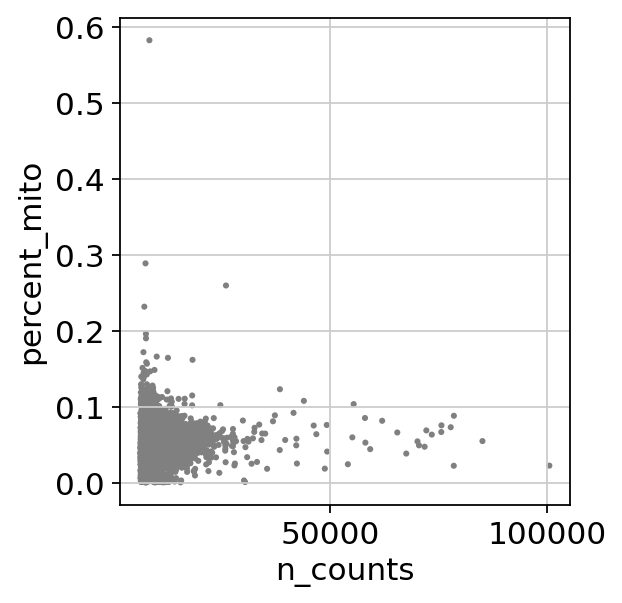

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [ ]:
# Filter mito percentage
adata = adata[adata.obs.percent_mito < 0.03]

In [ ]:
# Filter out genes that present in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

filtered out 23429 genes that are detected in less than 3 cells


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [ ]:
adata

AnnData object with n_obs × n_vars = 777 × 16117
    obs: 'sample', 'n_genes', 'n_counts', 'percent_mito'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Visualizing count distributions
Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

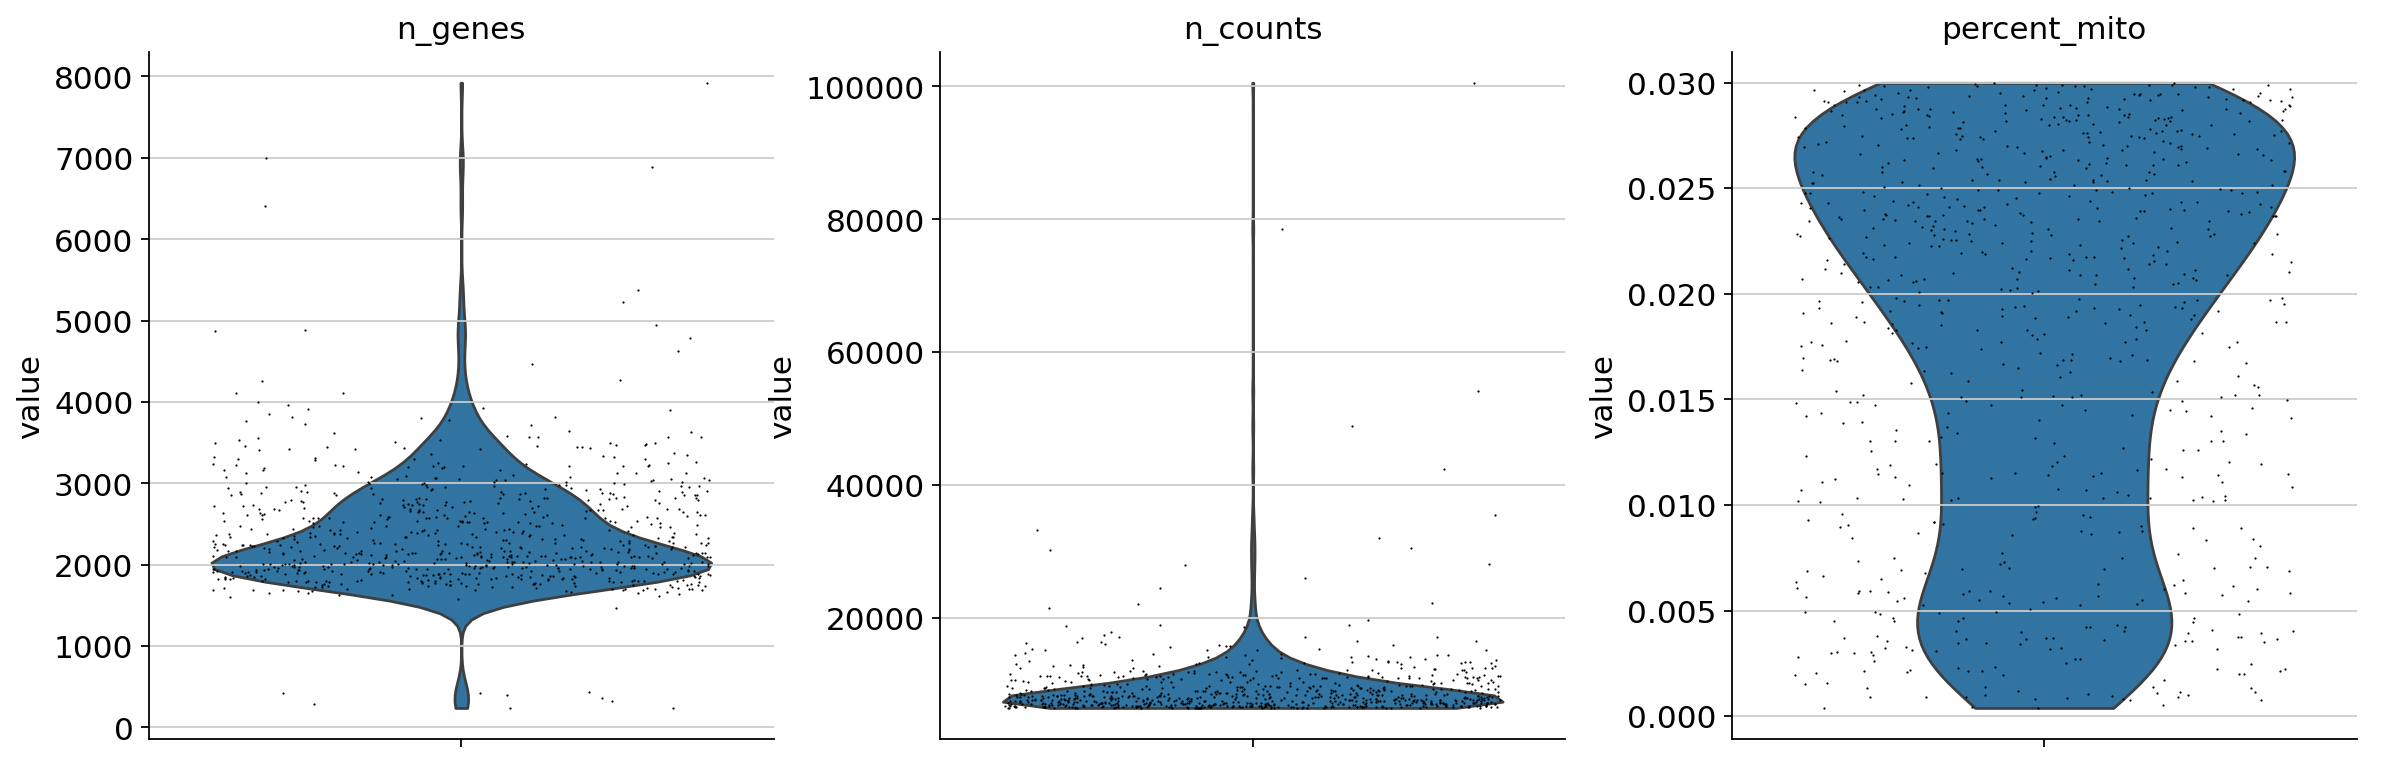

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

## Step 7: Basic Analysis

In this part of the tutorial, the cells are clustered by the [Leiden](https://www.nature.com/articles/s41598-019-41695-z) algorithm.

### Normalize the counts

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:03)


### Identify highly variable genes

extracting highly variable genes


/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


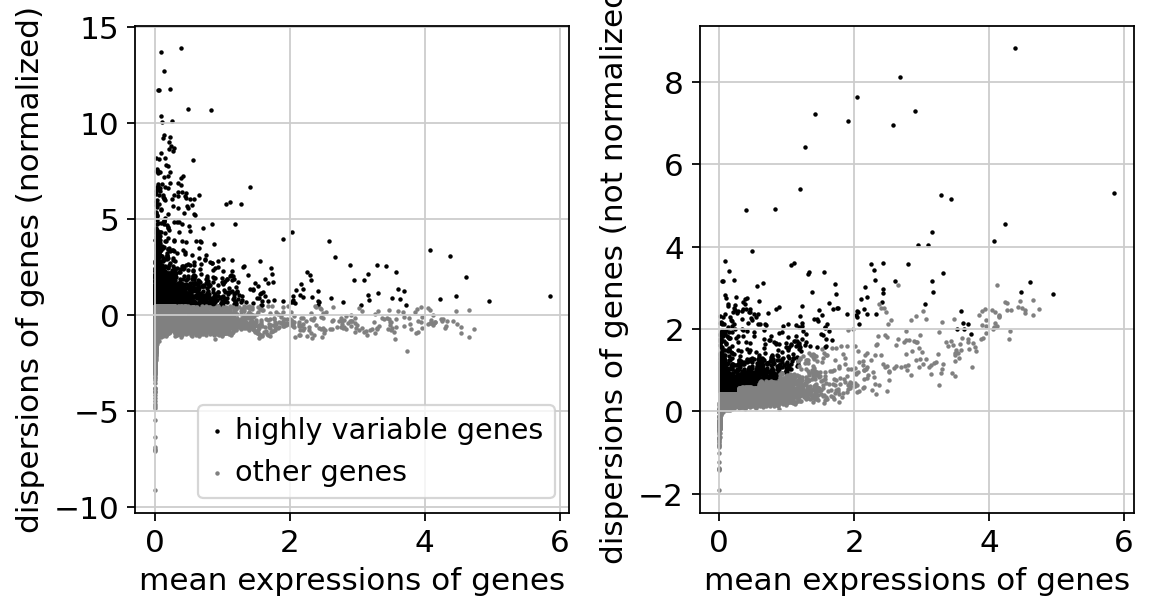

In [ ]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [ ]:
# Scale unit variance and zero mean; clip to 10
sc.pp.scale(adata, max_value=10)

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


### Clustering and visualization
There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using Leiden clustering, which is a popular method for clustering single-cell RNA-seq data. The method was published in

- Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

In [ ]:
# Cluster the cells using Leiden clustering
sc.pp.pca(adata, use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.leiden(adata)

computing PCA
    with n_comps=10
    finished (0:00:00)
computing neighbors


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
running Leiden clustering


/tmp/ipython-input-222151724.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


It is useful to revisit the PCA project with points colored by cluster. Previously we computed the PCA projection directly; here we use a function in ScanPy which does the same.

### PCA

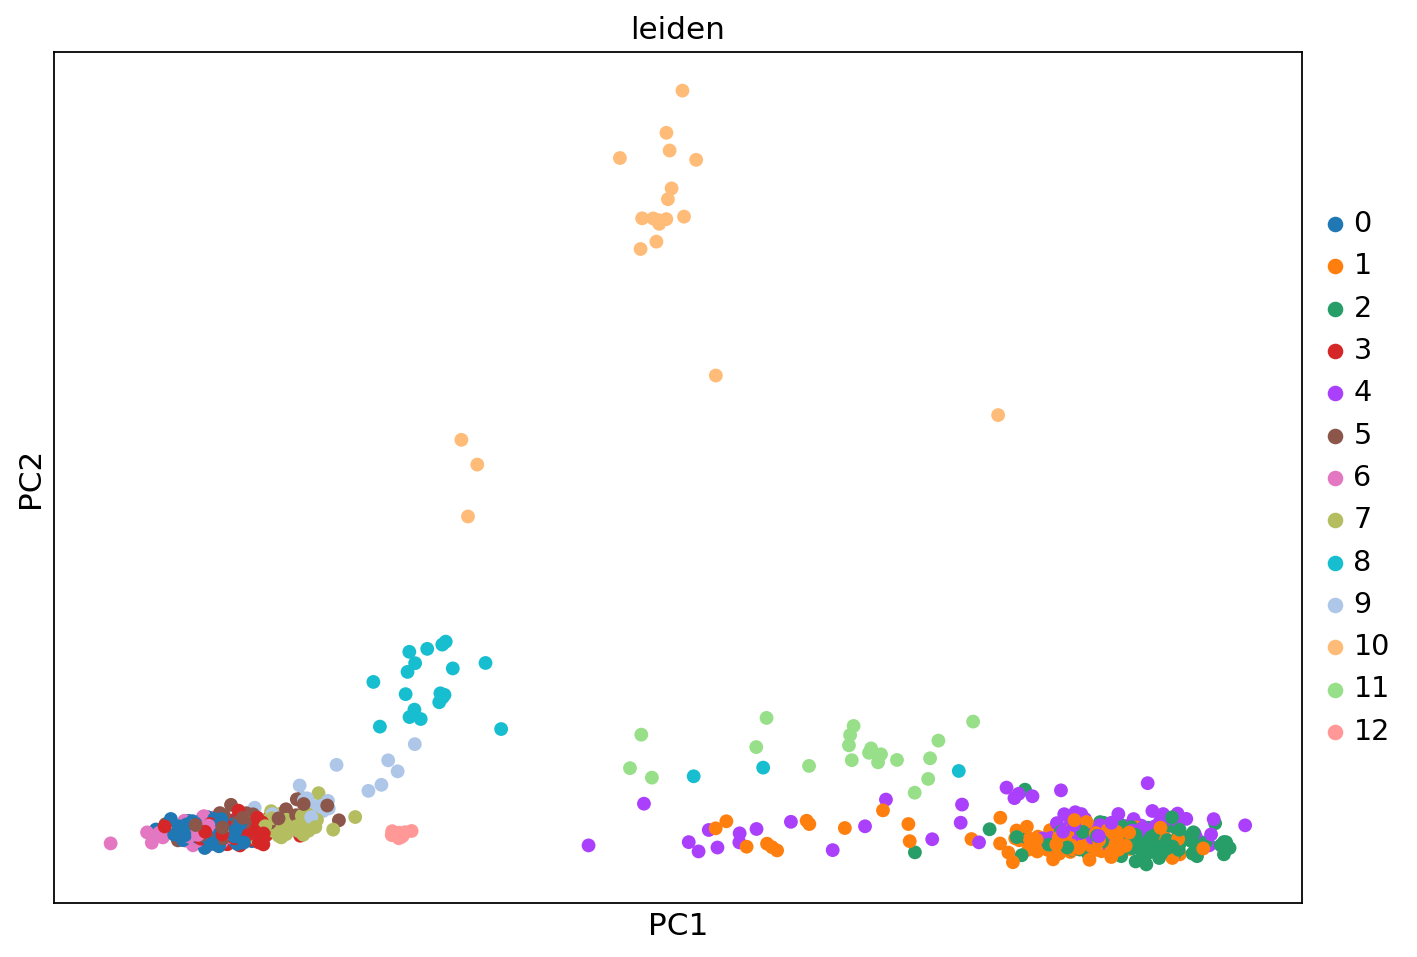

In [ ]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='leiden', ax=ax)

The PCA representation is the result a *linear* map of the data from its ambient dimension, to low dimension (in the case above 2D). While such projections are useful, there are *non-linear* methods that can capture non-linear geometry in the data.

## UMAP

UMAP stands for Uniform Manifold Approximation and Projection is a non-linear dimensionality reduction techinque described in

* Leland McInnes and John Healy and James Melville, "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" 2018 1802.03426 arXiv stat.ML


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


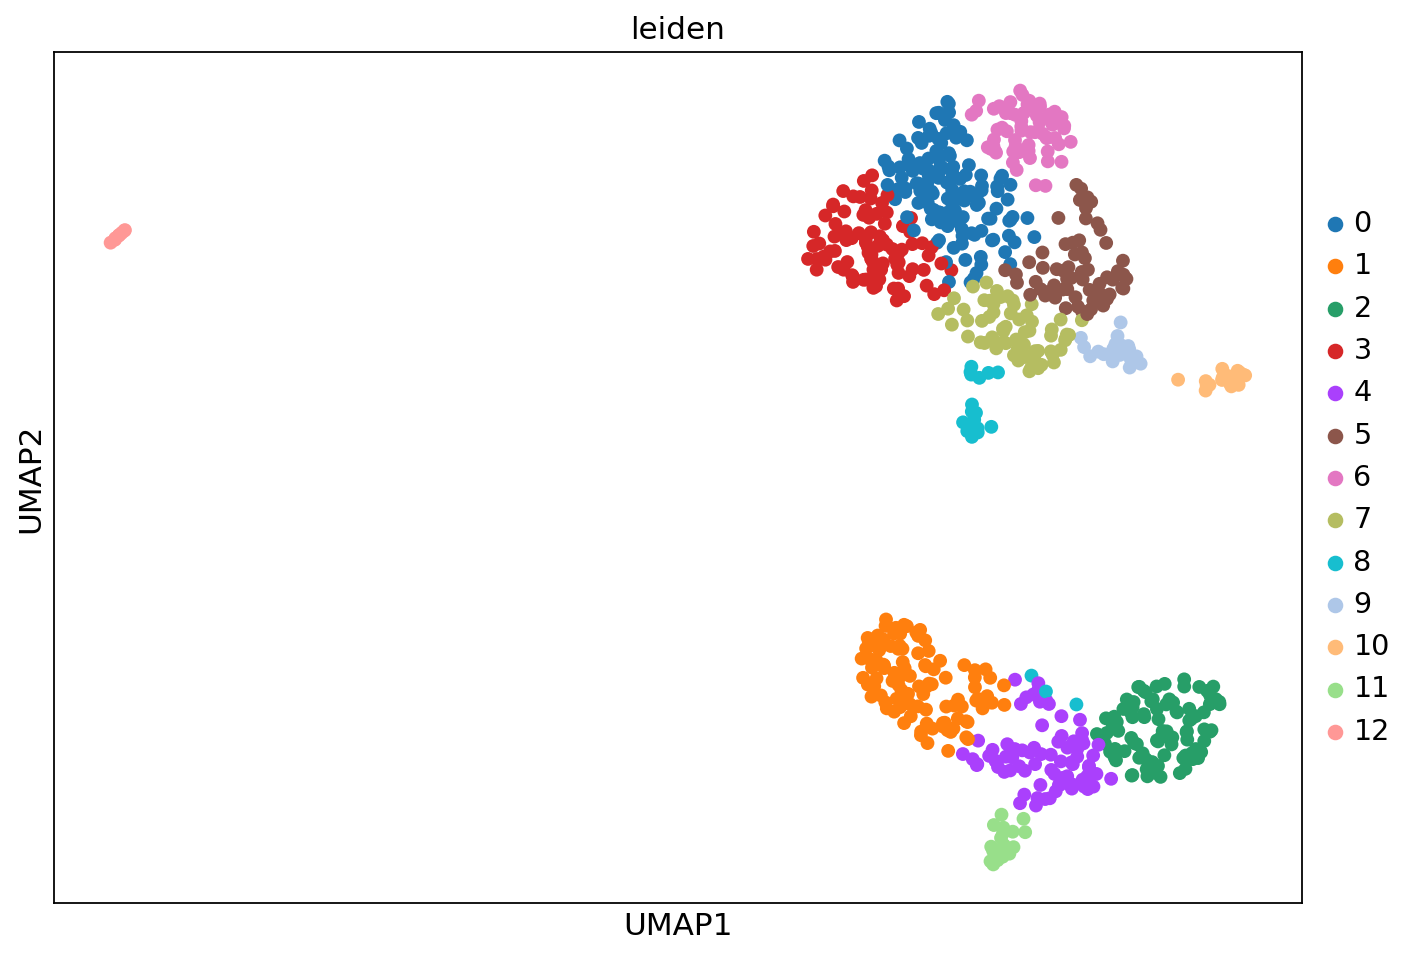

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='leiden', ax=ax)